<a href="https://colab.research.google.com/github/avihan-oss/Malaria-Detection-CNN/blob/main/CNN_Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Theory and Background :**

Convolutional Neural Networks (CNNs) are a class of deep learning models specifically designed for image-based data. Unlike traditional fully connected neural networks, CNNs exploit the spatial structure of images by using convolutional filters that learn local patterns such as edges, textures, and shapes. These learned features are then combined across layers to capture increasingly complex visual representations.



A typical CNN consists of convolutional layers, which apply learnable kernels to extract features from input images, followed by pooling layers that reduce spatial dimensionality while preserving important information. This hierarchical feature extraction allows CNNs to achieve strong performance on visual recognition tasks. Fully connected layers at the end of the network perform classification based on the extracted features.



In medical image analysis, CNNs are particularly effective because disease-related patterns are often subtle and localized. In the context of malaria detection, microscopic blood smear images contain visual cues such as parasite shapes and cell distortions that are difficult to capture using handcrafted features. CNNs can automatically learn these discriminative features directly from data, making them well-suited for automated disease screening tasks.



In this project, a CNN is trained to classify blood cell images as parasitized or uninfected using an official malaria dataset. The model is trained end-to-end on labeled image data, and its performance is evaluated on a held-out test set to assess generalization. This approach demonstrates how deep learning techniques can be applied to real-world healthcare imaging problems.

In [1]:
"""
Malaria Parasite Detection using Convolutional Neural Networks

This script trains a CNN to classify microscopic blood cell images
as parasitized or uninfected using the official TFDS malaria dataset.
"""

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# -------------------------------
# Configuration parameters
# -------------------------------

IMG_SIZE = 128          # Image resolution (height = width)
BATCH_SIZE = 32         # Number of samples per training batch
EPOCHS = 5              # Training epochs (sufficient for convergence)
AUTOTUNE = tf.data.AUTOTUNE


In [3]:
# -------------------------------
# Load malaria dataset
# -------------------------------

(ds_train, ds_test), ds_info = tfds.load(
    "malaria",
    split=["train[:80%]", "train[80%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.WFGG9X_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


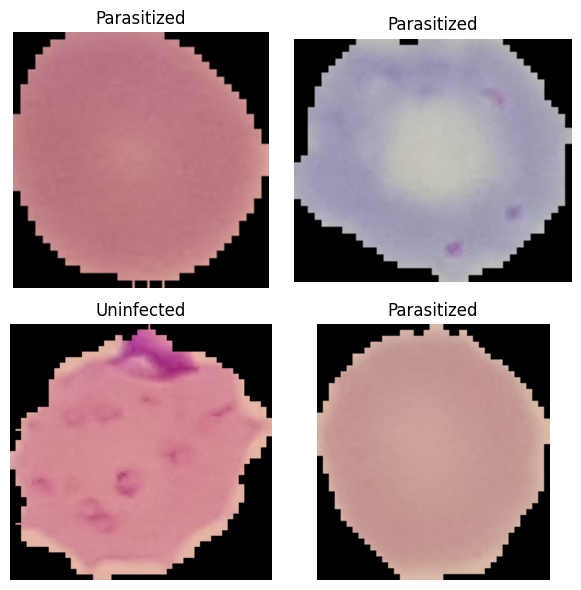

In [4]:
def visualize_samples(dataset, num_samples=4):
    """Visualize sample images with labels to verify dataset integrity."""
    plt.figure(figsize=(6, 6))

    for i, (image, label) in enumerate(dataset.take(num_samples)):
        plt.subplot(2, 2, i + 1)
        plt.imshow(image)
        plt.title("Parasitized" if label == 1 else "Uninfected")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


visualize_samples(ds_train)


In [5]:
# -------------------------------
# Image preprocessing
# -------------------------------

def preprocess_image(image, label):
    """
    Preprocess input images for CNN training.

    Steps:
    1. Resize to fixed dimensions
    2. Normalize pixel values to [0, 1]

    Args:
        image (Tensor): Raw RGB image
        label (Tensor): Binary class label

    Returns:
        image (Tensor): Preprocessed image
        label (Tensor): Unchanged label
    """
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


In [6]:
# -------------------------------
# Dataset pipelines
# -------------------------------

train_ds = (
    ds_train
    .map(preprocess_image, num_parallel_calls=AUTOTUNE)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    ds_test
    .map(preprocess_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)


In [7]:
# -------------------------------
# CNN model definition
# -------------------------------

def build_cnn_model(input_shape):
    """
    Build a convolutional neural network for binary image classification.

    Architecture:
    - 3 convolutional blocks (Conv + MaxPool)
    - Fully connected classifier
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu",
                               input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    return model


In [8]:
# -------------------------------
# Compile model
# -------------------------------

model = build_cnn_model((IMG_SIZE, IMG_SIZE, 3))

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# -------------------------------
# Model training
# -------------------------------

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS
)


Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 709s 1s/step - accuracy: 0.7368 - loss: 0.4851 - val_accuracy: 0.9516 - val_loss: 0.1749
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 679s 984ms/step - accuracy: 0.9540 - loss: 0.1424 - val_accuracy: 0.9543 - val_loss: 0.1537
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 672s 970ms/step - accuracy: 0.9606 - loss: 0.1197 - val_accuracy: 0.9574 - val_loss: 0.1434
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 667s 949ms/step - accuracy: 0.9639 - loss: 0.1060 - val_accuracy: 0.9559 - val_loss: 0.1454
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 658s 954ms/step - accuracy: 0.9701 - loss: 0.0852 - val_accuracy: 0.9532 - val_loss: 0.1676


In [10]:
# -------------------------------
# Model evaluation
# -------------------------------

test_loss, test_accuracy = model.evaluate(test_ds)

print(f"Test Accuracy: {test_accuracy:.4f}")


173/173 ━━━━━━━━━━━━━━━━━━━━ 48s 275ms/step - accuracy: 0.9516 - loss: 0.1617
Test Accuracy: 0.9532


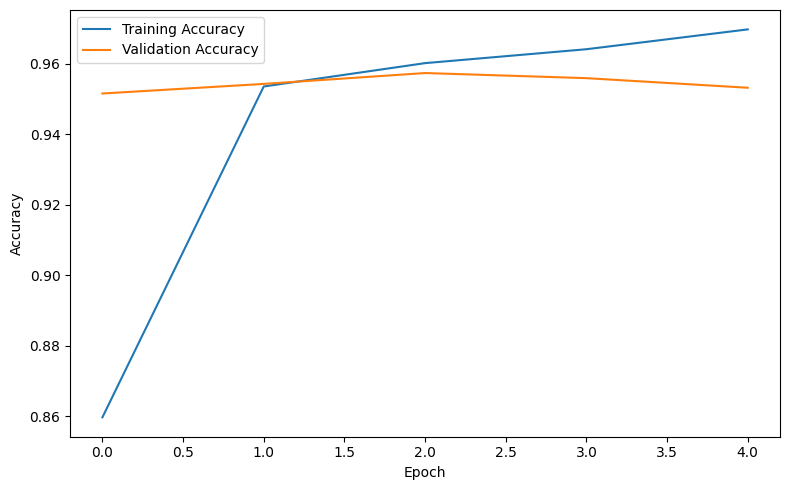

In [11]:
# -------------------------------
# Training diagnostics
# -------------------------------

def plot_training_curves(history):
    """Plot training and validation accuracy."""
    plt.figure(figsize=(8, 5))
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_training_curves(history)


# **Conclusion :**

In this project, a Convolutional Neural Network was developed and trained to classify microscopic blood smear images as parasitized or uninfected using an official medical imaging dataset. The model achieved high classification accuracy, demonstrating the effectiveness of convolutional architectures for visual pattern recognition in healthcare applications. While the approach shows strong performance under controlled conditions, real-world deployment would require further validation, robustness testing, and clinical oversight. This project highlights the practical application of deep learning techniques to medical image analysis and automated disease screening.

**This project was implemented as part of a self-directed study in machine learning and healthcare analytics.**